Using TensorFlow backend.


Read  4305


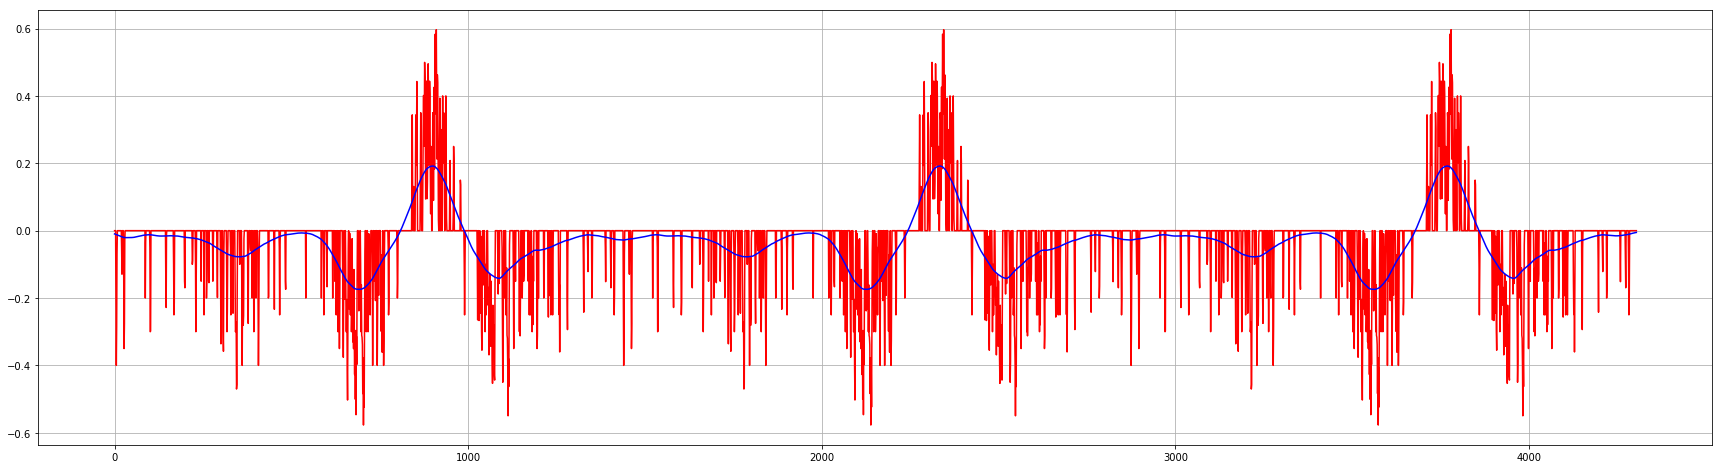

Samples are reduce from  4305  to  2061


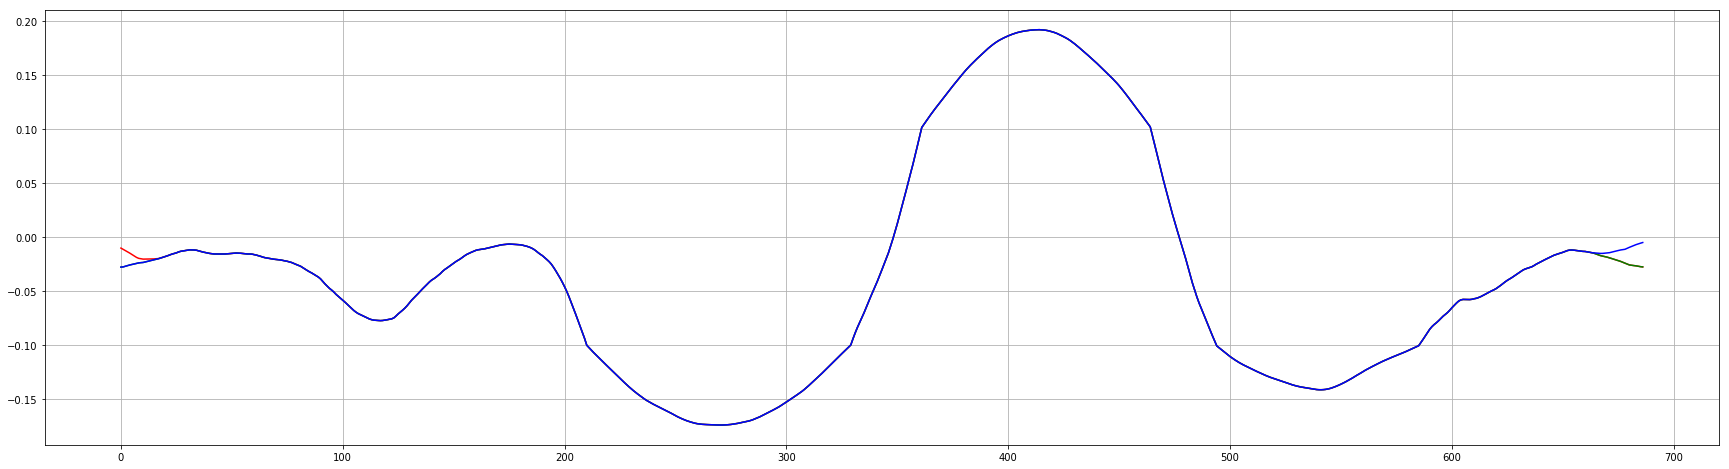

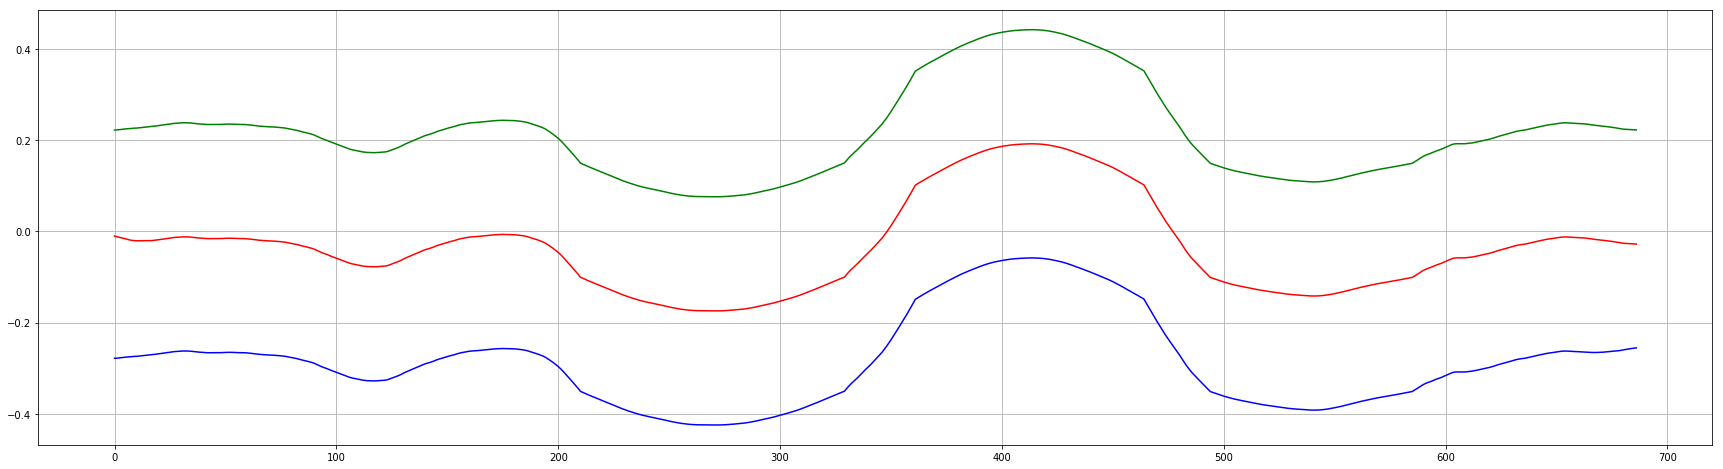

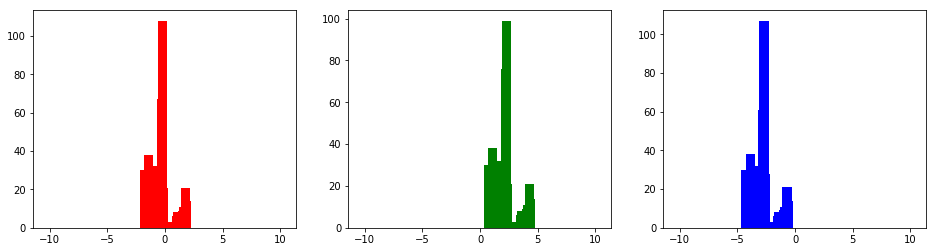

In [1]:
import utils
import numpy as np

path = 'data/track1-test/'
samples = utils.load_data(path,True)

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt

path = 'data/track1-test/'
samples = utils.load_data(path)
gen = utils.generator(samples,32)

Using TensorFlow backend.


Read  1435
Samples are reduce from  1435  to  687


Generated a fresh batch


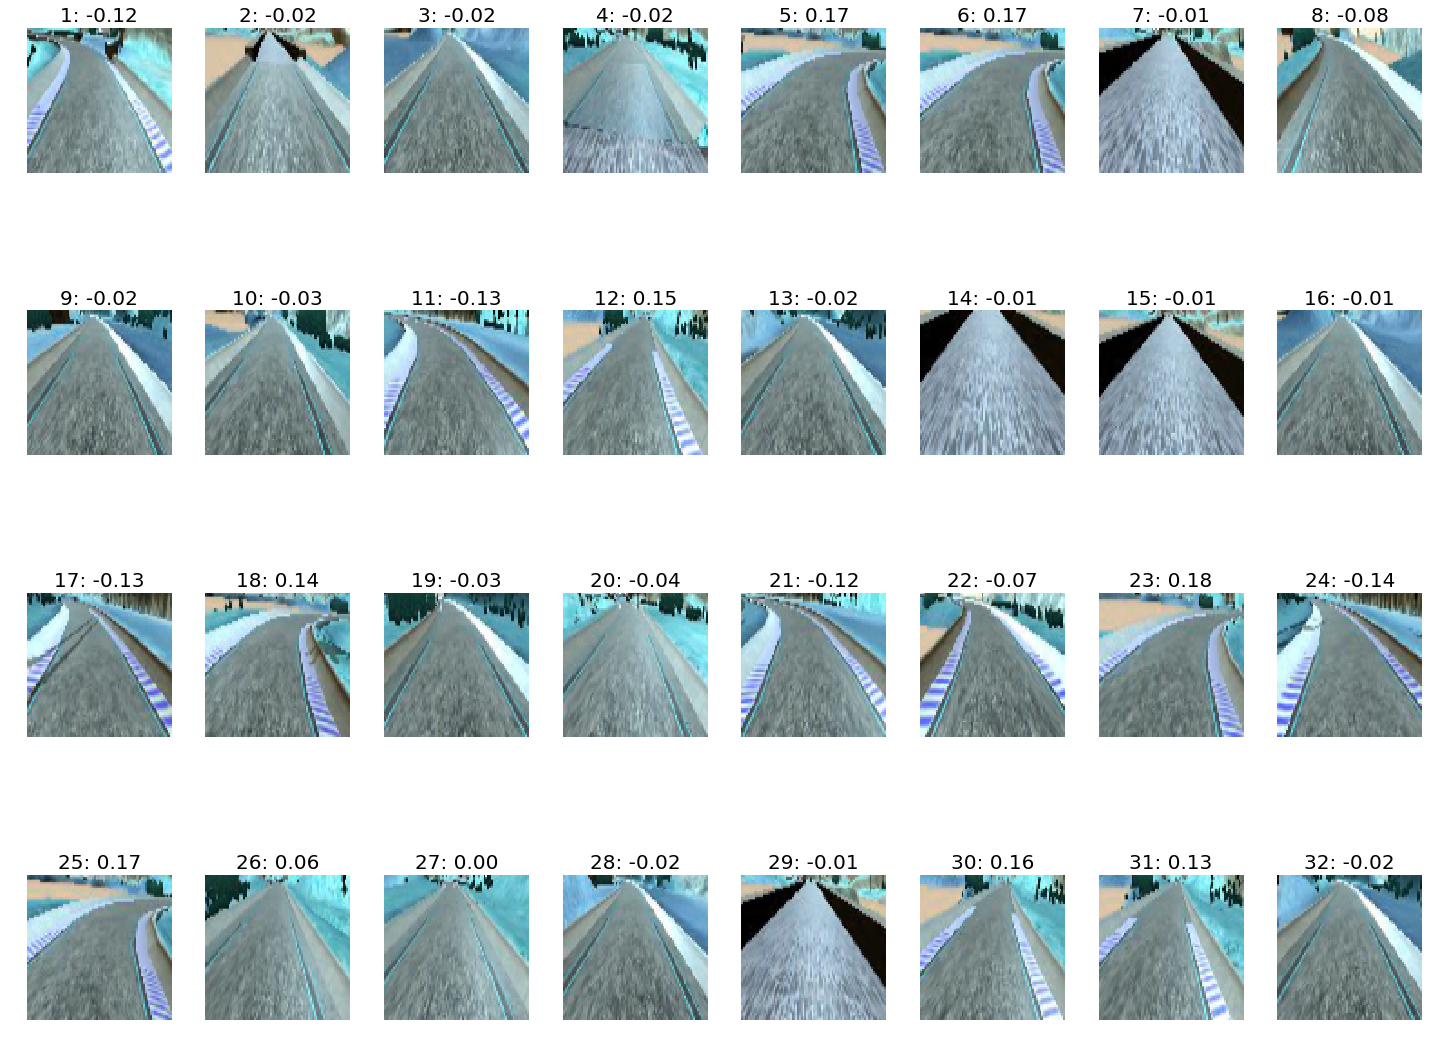

In [3]:
# Run the previous cell first
images,steerings = next(gen)
print("Generated a fresh batch")
fig = plt.figure(figsize=(20, 20))
col = 8
row = int(len(images) / col) + 1
i = 1
for img,steering in zip(images,steerings):
    plt.subplot(row, col, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title("{}: {:2.2f}".format(i, steering), fontsize=20)
    i = i + 1
plt.tight_layout()
plt.show()

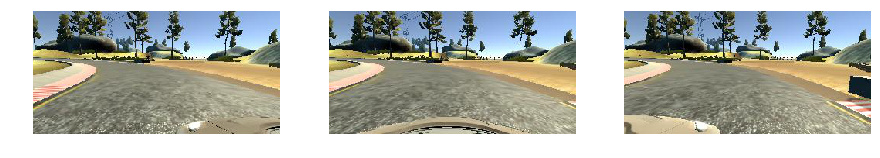

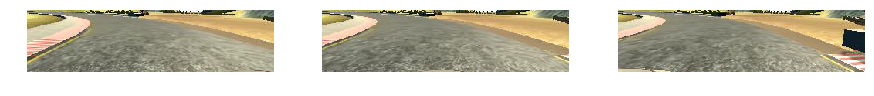

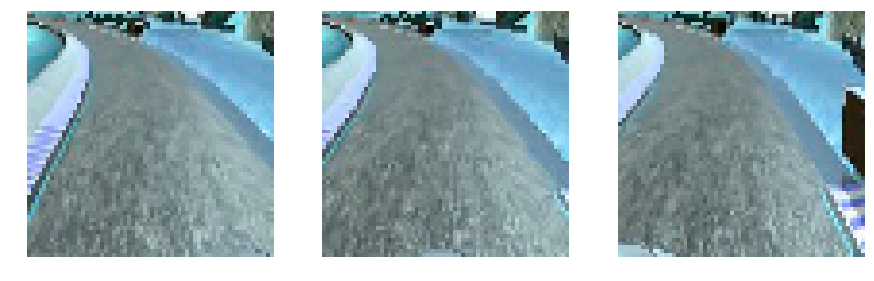

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def crop(img):
    width = img.size[0]
    height = img.size[1]
    crop_top = 60
    crop_bottom = 20
    img_cropped = img.crop((0,
                            crop_top,
                            width,
                            height - crop_bottom))
    return img_cropped

def plot(images):
    plt.figure(figsize=(15,15))
    plt.subplot(1, 3, 1)
    plt.imshow(images[0])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(images[1])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(images[2])
    plt.axis('off')
    plt.show()

%matplotlib inline
# file = "data/track1-center/IMG/center_2017_06_10_00_43_05_338.jpg"
file = "data/track1-center1/IMG/left_2017_06_10_17_28_39_772.jpg"
file1 = "data/track1-center1/IMG/center_2017_06_10_17_28_39_772.jpg"
file2 = "data/track1-center1/IMG/right_2017_06_10_17_28_39_772.jpg"

imgs= [Image.open(file),Image.open(file1),Image.open(file2)]
imgs_cropped = [crop(imgs[0]),crop(imgs[1]),crop(imgs[2])]
plot(imgs)
plot(imgs_cropped)

img_cv = [utils.preprocess_image(file),utils.preprocess_image(file1),utils.preprocess_image(file2)]
plot(img_cv)

Steering predict = 2.1094264462590218


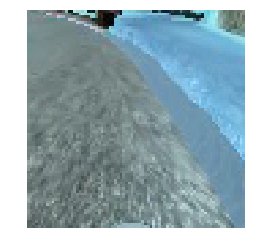

In [21]:
import os
path = 'correction'
files = os.listdir(path)
files = [os.path.join(path, file) for file in files]
print(files)

['correction/2017_06_19_01_39_41_722.jpg', 'correction/2017_06_19_02_39_58_524.jpg', 'correction/2017_06_19_01_39_41_547.jpg', 'correction/2017_06_19_02_39_58_550.jpg', 'correction/2017_06_19_02_39_58_500.jpg', 'correction/2017_06_19_02_39_57_408.jpg', 'correction/2017_06_19_02_36_22_796.jpg', 'correction/2017_06_19_01_39_41_606.jpg', 'correction/2017_06_19_02_39_58_773.jpg', 'correction/2017_06_19_02_39_57_924.jpg', 'correction/2017_06_19_01_39_41_813.jpg', 'correction/2017_06_19_02_39_58_618.jpg', 'correction/2017_06_19_02_39_58_025.jpg', 'correction/2017_06_19_02_39_57_431.jpg', 'correction/2017_06_19_02_36_22_925.jpg', 'correction/2017_06_19_02_39_57_457.jpg', 'correction/2017_06_19_02_36_22_700.jpg', 'correction/2017_06_19_02_39_58_666.jpg', 'correction/2017_06_19_01_39_41_788.jpg', 'correction/2017_06_19_02_39_57_585.jpg', 'correction/2017_06_19_02_39_58_224.jpg', 'correction/2017_06_19_02_39_57_875.jpg', 'correction/2017_06_19_02_39_57_764.jpg', 'correction/2017_06_19_01_39_41_6

Using TensorFlow backend.


Read  4305
Samples are reduce from  4305  to  2061
Testing prediction on 1031 images
Plotting results  42


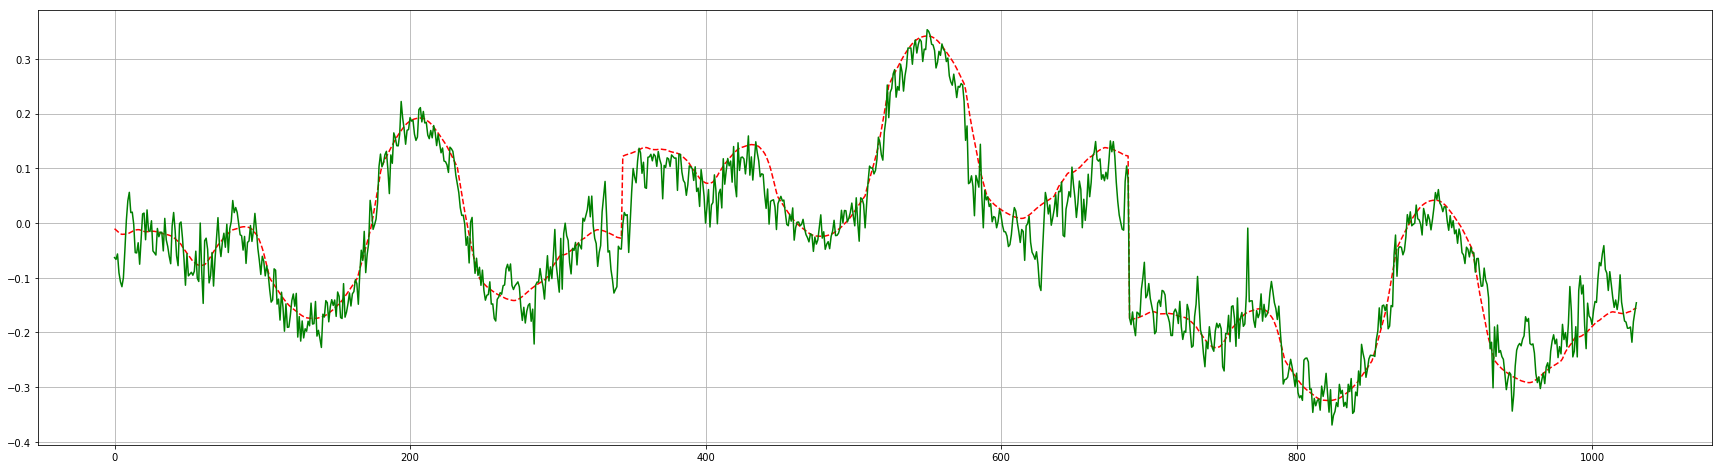

Result: [Ground truth | Prediction | Error]


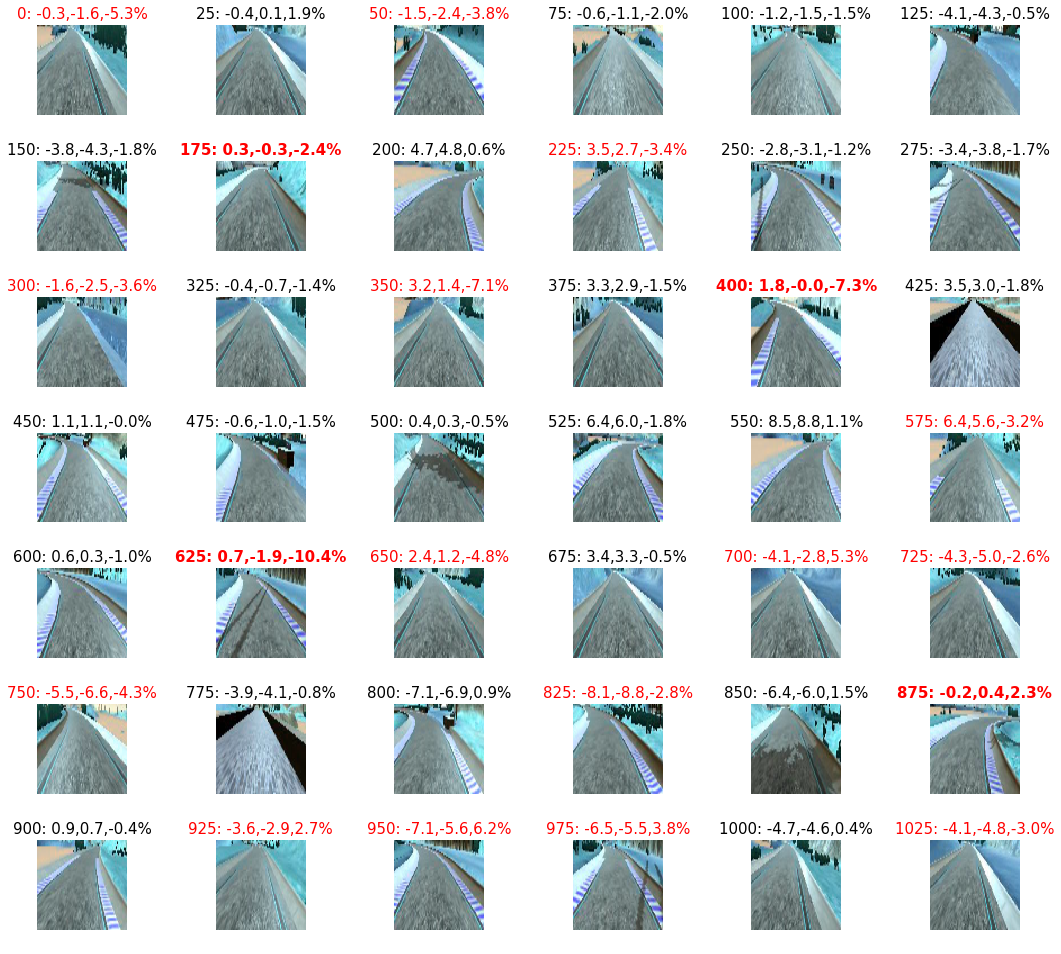

Test completed


In [1]:
import utils
utils.test_model('model_nvidia3.h5','data/track1-test/',True)

Read  4305
Testing prediction on 718 images
Plotting results  29


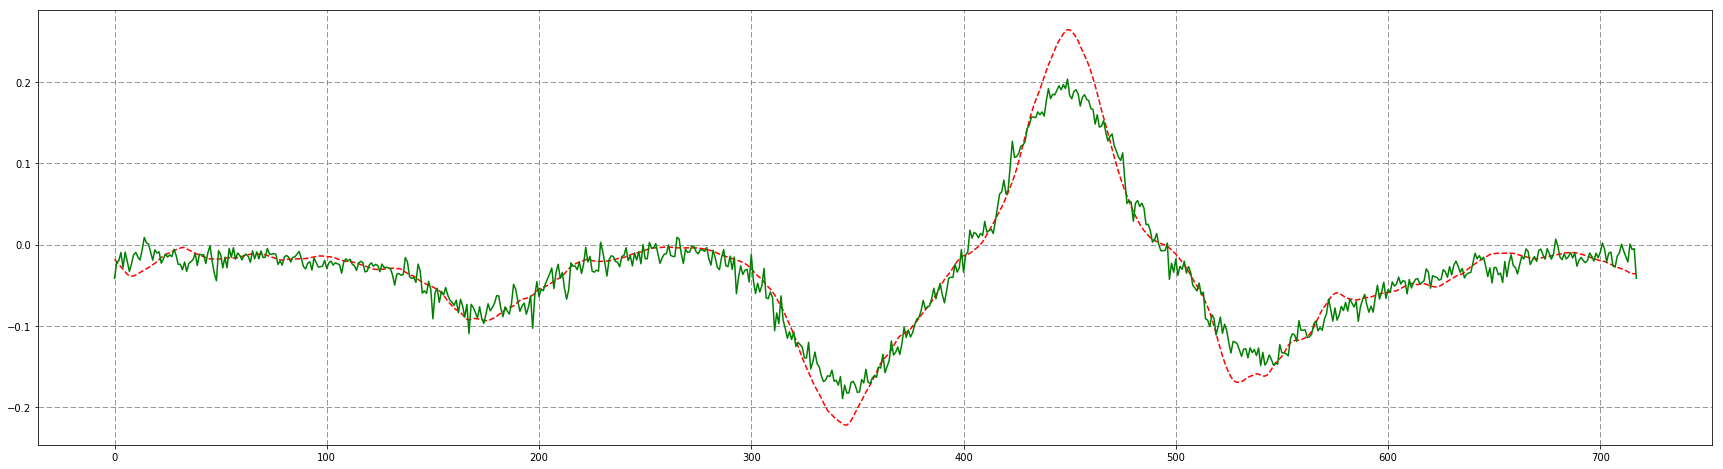

Result: [Ground truth | Prediction | Error]


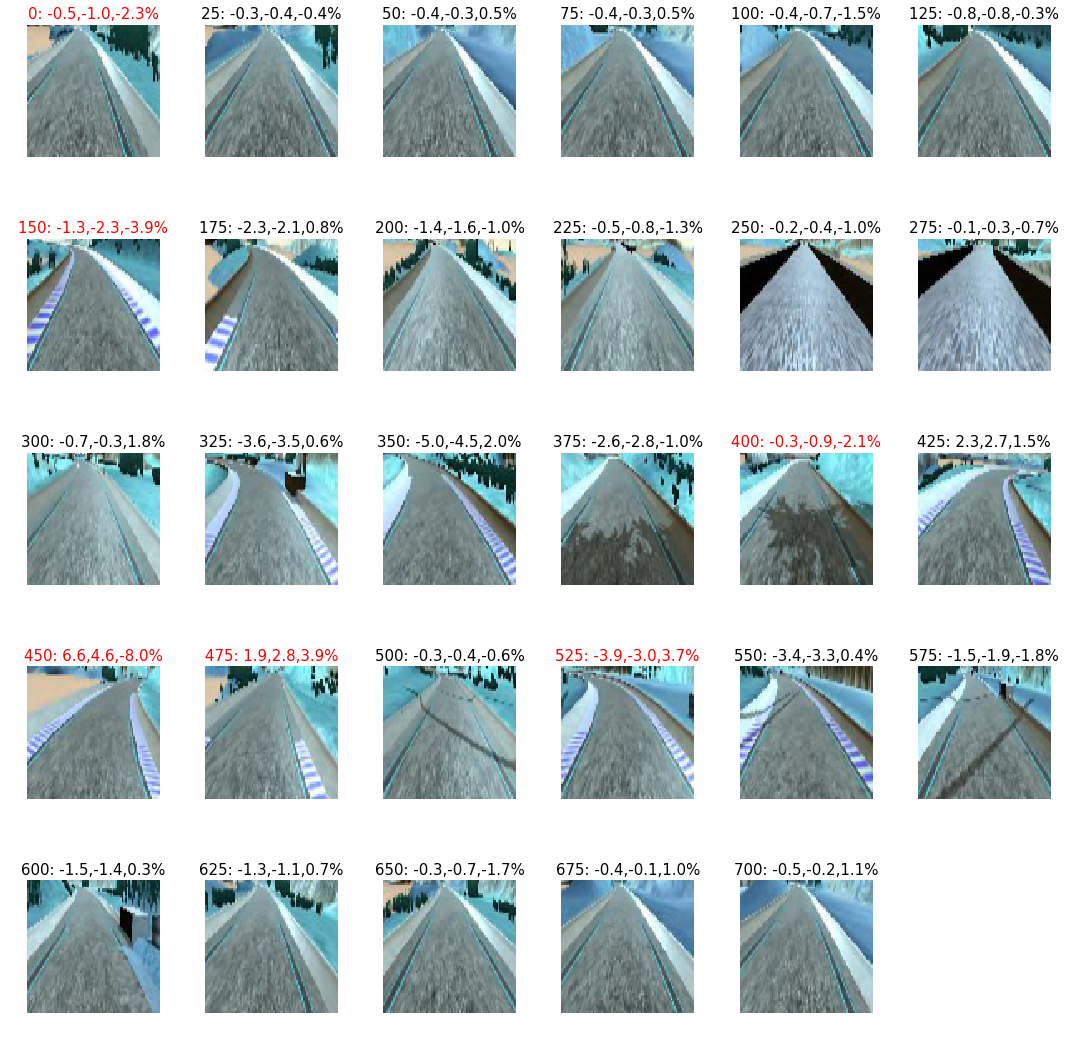

Test completed


In [8]:
import utils
utils.test_model('model_nvidia2.h5','data/track1-test/',True)

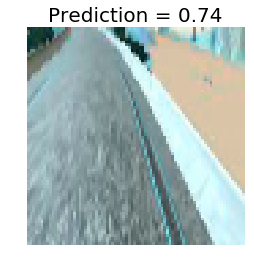

In [3]:
from keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import utils

#img_file = "data/track1-center1/IMG/right_2017_06_10_17_28_39_772.jpg"
img_file = "/home/mma/udacity/CarND-Behavioral-Cloning-P3/log/2017_06_21_07_25_45_520.jpg"

model = load_model('model_nvidia2.h5')
img = utils.open_image(img_file)
steering_angle = float(model.predict(img[None, :, :, :], batch_size=1))
plt.imshow(img)
plt.title("Prediction = {:.2f}".format(steering_angle*25),fontsize=20)
plt.axis('off')
plt.show()

Using TensorFlow backend.


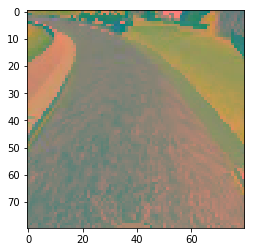

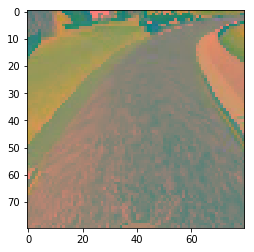

In [1]:
import utils
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

file1 = "data/track1-center1/IMG/center_2017_06_10_17_28_39_772.jpg"
img = utils.open_image(file1)
img1 = np.fliplr(img)
plt.imshow(img)
plt.show()
plt.imshow(img1)
plt.show()
